# Part 2 - Validation on testes peptides

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

import joblib
from sklearn.decomposition import PCA
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
# This function wil convert the undefined MIC values to 100.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        mic_value = float(mic_value.replace('>', ''))
        v = 100
        return v
    else:
        return float(mic_value)

In [3]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('results/v01.2/predictions_validation_set_v01.2.csv')
meta_data

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,hemolysis_pred_v02,selectivity_pred_v02
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,-3.285721,0.307504
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,-6.084995,0.272666
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665,-6.281200,0.345484
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,-1.958412,0.618075
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,-2.783794,0.578861
5,PG1_3mut_1210489,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,<-0.25,16,0.735867,1.070920,-13.542688,-0.695068,-2.916473,0.343804
6,PG1_3mut_1536372,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,<-0.25,2,0.906433,0.258366,-3.345207,-0.416047,-3.252567,0.452450
7,PG1_3mut_1147726,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,<-0.25,16,0.043860,-0.153815,-12.337255,-0.839417,-1.449774,0.491094
8,PG1_3mut_1980555,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,<-0.25,32,0.116959,0.573184,-21.809423,-0.699560,-11.984425,0.122605
9,PG1_3mut_1658870,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,<-0.25,64,0.092593,0.772756,-9.999792,-0.342884,-4.005482,0.379449


## Load embeddings

In [ ]:
######################## Load the embedding ######################
dir_path = 'data/embedding/esm2_15B_PG1_validation/'
embeddings = {}
for file in os.listdir(dir_path):
        file_path = str(dir_path) + file 
        label = file.split('.pt')[0]
        embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID2', right_index=True)


features = data.iloc[:,meta_data.shape[1]:]
features

# Predictions

## Hemolysis

In [8]:
# load PCA weights and models for hemolysis prediction
pca30 = joblib.load('models/pca30_weights_v03.pkl') # hemo
X30 = pca30.transform(features)
hemo = joblib.load('models/model_v03_Lasso30_esm2_15B_hemolysis_regression.pkl')

In [9]:
res_hemo = data.iloc[:,:meta_data.shape[1]]

# calculates the the hemolysis score
pred = hemo.predict(X30)
res_hemo['hemolysis_pred_v02']= pred

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred_v02 <= 2').shape[0]} peptides with predicted hemolysis% <= 2%")

31 peptides with predicted hemolysis% <= 2%


In [10]:
# Model evaluation on test data
true_hemo = res_hemo['%hemo']
pred_hemo = res_hemo['hemolysis_pred_v02']

r2 = metrics.r2_score(true_hemo, pred_hemo)
mae = metrics.mean_absolute_error(true_hemo, pred_hemo)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(true_hemo, pred_hemo)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -1.4950545890455826, MAE: 3.5165091179551724
Spearman correlation coefficient: 0.32
P-value: 0.06


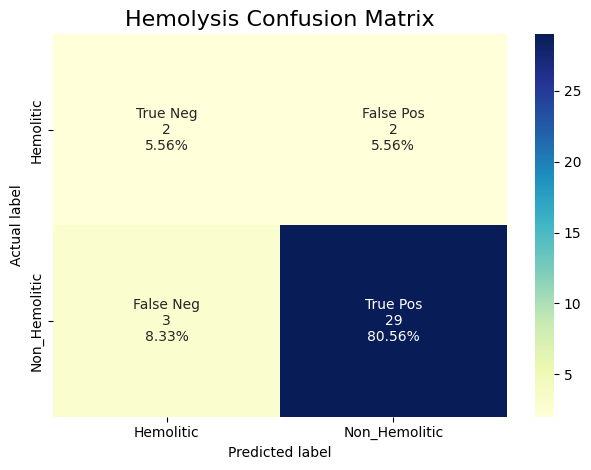

In [11]:
#confusion_matrix, 
true = [1 if x <=2 else 0 for x in true_hemo]
pred = [1 if x<=2 else 0 for x in pred_hemo]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Hemolitic', 'Non_Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolysis Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [12]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.86
Recall: 0.91
Precision: 0.94
F1 Score: 0.92


## Selectivity

In [14]:
cutoff_sel = 0.5

In [16]:

# load PCA weights and models for selectivity prediction
pca35 = joblib.load('models/pca35_weights_v03.pkl') # sel
X35 = pca35.transform(features)

model_sel = joblib.load('models/model_v03_Lasso35_esm2_15B_selectivity_regression.pkl')

In [17]:
res_sel = data.iloc[:,:meta_data.shape[1]]
# calculates the selectivity score
pred = model_sel.predict(X35)
res_sel['selectivity_pred_v02']= pred

#number of peptides with hemolysis score < 1
print(f"{res_sel.query('selectivity_pred_v02 < 1').shape[0]} peptides with predicted hemolysis% < 0.5")

32 peptides with predicted hemolysis% < 0.5


In [18]:
res = res_sel[~res_sel['L10Select'].isna()]
# Model evaluation on test data
true_sel = res['L10Select']
pred_sel = res['selectivity_pred_v02']

r2 = metrics.r2_score(true_sel, pred_sel)
mae = metrics.mean_absolute_error(true_sel, pred_sel)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(true_sel, pred_sel)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -0.06151500617122685, MAE: 0.4316403056751375
Spearman correlation coefficient: 0.30
P-value: 0.12


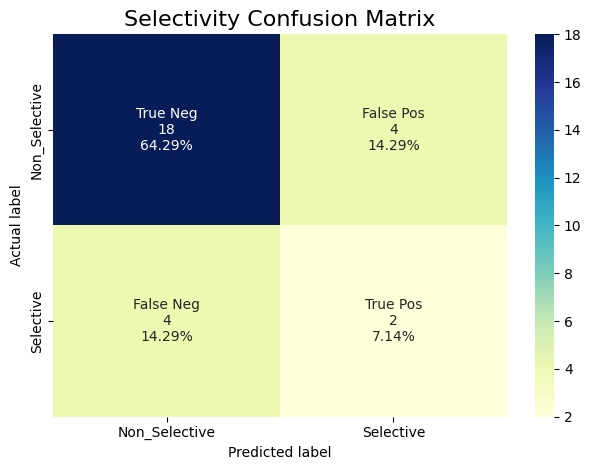

In [19]:
#confusion_matrix, 
true = [1 if x<=cutoff_sel else 0 for x in true_sel]
pred = [1 if x<=cutoff_sel else 0 for x in pred_sel]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Selective', 'Selective']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Selectivity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [20]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.71
Recall: 0.33
Precision: 0.33
F1 Score: 0.33


## Activity

In [73]:
cutoff=90

In [74]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    

In [75]:
# load PCA weights and models for activity prediction
pca40 = joblib.load('models/pca40_weights_v03.pkl') # mic
X40 = pca40.transform(features)
#
model_mic = joblib.load('models/model_v03_logR40_esm2_15B_activity_classification.pkl')

In [76]:
res_mic = data.iloc[:,:meta_data.shape[1]]

# calculates the probability of being active
prob= model_mic.predict_proba(X40)
res_mic['MIC_pred_v02']= [(x[1]*100).round(2) for x in prob]

#number of peptides with hemolysis score < 1
res_mic.query('MIC_pred_v02 > 90')

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC_pred_v02
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08,90.66
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97,94.16
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19,92.43
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20,94.70
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51,96.11
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28,97.32
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57,95.09
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90,90.28
10,bsPG-1.11,RGGRLRYCRRRGTVCVGR,-----R-----GT-----,-0.28,6.742145,PG1_3mut_1618529,CP,>64,0.268031,NaN,NaN,100.0,-0.28,-2.79,90.71
13,bsPG-1.14,RGGRLCTARRRFCVHVGR,------TA------H---,-0.22,5.835569,PG1_3mut_1926344,-0.25-0,16,0.638402,1.009214,10.214425,100.0,-0.22,-2.34,91.72


In [77]:
# Load meta data
res_mic['Active'] = [convert_mic(x) for x in res_mic['MIC MH']]
res_mic

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC_pred_v02,Active
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.0,-0.82,-3.26,87.40,0
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08,90.66,1
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97,94.16,0
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19,92.43,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20,94.70,1
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.0,-0.43,-9.15,85.81,0
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51,96.11,1
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28,97.32,0
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57,95.09,0
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90,90.28,0


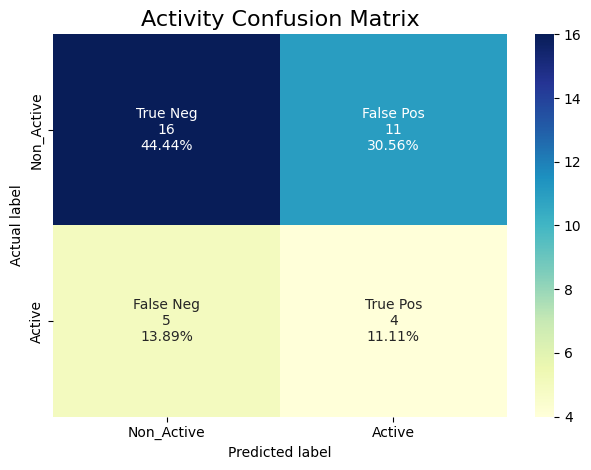

In [78]:
#confusion_matrix, 
true = res_mic['Active']
pred = [1 if x>cutoff else 0 for x in res_mic['MIC_pred_v02']]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Activity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [79]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.56
Recall: 0.44
Precision: 0.27
F1 Score: 0.33


# Overall Performance V1 x V2

In [13]:
res = pd.read_csv('results/v01.2/predictions_validation_set_v01.2.csv')
res['MIC'] = [convert_mic(x) for x in res['MIC MH']]
res['L10Select'].fillna(100, inplace=True)

res.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,activity_pred_v01.2,hemolysis_pred_v02,selectivity_pred_v02,activity_pred_v02,MIC
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,100.0,-4.054558,0.448899,92.34,16.0
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,100.0,-6.763184,0.368799,88.34,4.0
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,100.000000,-14.385390,-1.305665,100.0,-8.310135,0.390410,95.37,100.0
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,100.0,-2.867607,0.552553,90.87,64.0
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,100.0,-3.139629,0.636513,94.94,8.0


In [14]:
# true values
true_act = [1 if x<=8 else 0 for x in res['MIC']]
true_hemo = [1 if x<=2 else 0 for x in res['%hemo']]
true_sel = [1 if x<0.5 else 0 for x in res['L10Select']]

pred_v01_act = [1 if x<=8 else 0 for x in res['activity_pred_v01.2']]
pred_v01_hemo = [1 if x<=2 else 0 for x in res['hemolysis_pred_v01.2']]
pred_v01_sel = [1 if x<0.5 else 0 for x in res['selectivity_pred_v01.2']]

pred_v02_act = [1 if x<=8 else 0 for x in res['activity_pred_v02']]
pred_v02_hemo = [1 if x<=2 else 0 for x in res['hemolysis_pred_v02']]
pred_v02_sel = [1 if x<0.5 else 0 for x in res['selectivity_pred_v02']]

In [15]:
df = pd.DataFrame()

In [16]:
# version 1
accuracy = metrics.accuracy_score(true_act, pred_v01_act)
recall = metrics.recall_score(true_act, pred_v01_act)
precision = metrics.precision_score(true_act, pred_v01_act)
f1_score = metrics.f1_score(true_act, pred_v01_act)

df_dict={'Version': 'V01', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 1
accuracy = metrics.accuracy_score(true_act, pred_v01_hemo)
recall = metrics.recall_score(true_act, pred_v01_hemo)
precision = metrics.precision_score(true_act, pred_v01_hemo)
f1_score = metrics.f1_score(true_act, pred_v01_hemo)

df_dict={'Version': 'V01', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 1
accuracy = metrics.accuracy_score(true_act, pred_v01_sel)
recall = metrics.recall_score(true_act, pred_v01_sel)
precision = metrics.precision_score(true_act, pred_v01_sel)
f1_score = metrics.f1_score(true_act, pred_v01_sel)

df_dict={'Version': 'V01', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])


/stor/work/Wilke/luiz/DMS_ML_AMP/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# version 2
accuracy = metrics.accuracy_score(true_act, pred_v02_act)
recall = metrics.recall_score(true_act, pred_v02_act)
precision = metrics.precision_score(true_act, pred_v02_act)
f1_score = metrics.f1_score(true_act, pred_v02_act)

df_dict={'Version': 'V02', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 2
accuracy = metrics.accuracy_score(true_act, pred_v02_hemo)
recall = metrics.recall_score(true_act, pred_v02_hemo)
precision = metrics.precision_score(true_act, pred_v02_hemo)
f1_score = metrics.f1_score(true_act, pred_v02_hemo)

df_dict={'Version': 'V02', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 2
accuracy = metrics.accuracy_score(true_act, pred_v02_sel)
recall = metrics.recall_score(true_act, pred_v02_sel)
precision = metrics.precision_score(true_act, pred_v02_sel)
f1_score = metrics.f1_score(true_act, pred_v02_sel)

df_dict={'Version': 'V02', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Activity,0.750000,0.000000,0.000000,0.000000
0,V01,Hemolysis,0.250000,1.000000,0.250000,0.400000
0,V01,Selectivity,0.194444,0.666667,0.187500,0.292683
0,V02,Activity,0.750000,0.111111,0.500000,0.181818
0,V02,Hemolysis,0.277778,0.777778,0.225806,0.350000
0,V02,Selectivity,0.638889,0.111111,0.166667,0.133333


In [18]:
# id_vars: Columns that should remain unaltered.
# value_vars: Columns that you want to melt (i.e., unpivot). These columns will be transformed from wide format to long format.
# var_name: Name of the new column that will store the melted columns' names (default is 'variable').
# value_name: Name of the new column that will store the values (default is 'value').

df_melted = pd.melt(df, 
        id_vars=['Version', 'Feature'],
        value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'],
        var_name='Metric',
        value_name='Score')

df_melted= df_melted.sort_values(by=['Version', 'Feature', 'Metric']).reset_index(drop=True)
df_melted

,Version,Feature,Metric,Score
0,V01,Activity,Accuracy,0.750000
1,V01,Activity,F1 Score,0.000000
2,V01,Activity,Precision,0.000000
3,V01,Activity,Recall,0.000000
4,V01,Hemolysis,Accuracy,0.250000
5,V01,Hemolysis,F1 Score,0.400000
6,V01,Hemolysis,Precision,0.250000
7,V01,Hemolysis,Recall,1.000000
8,V01,Selectivity,Accuracy,0.194444
9,V01,Selectivity,F1 Score,0.292683


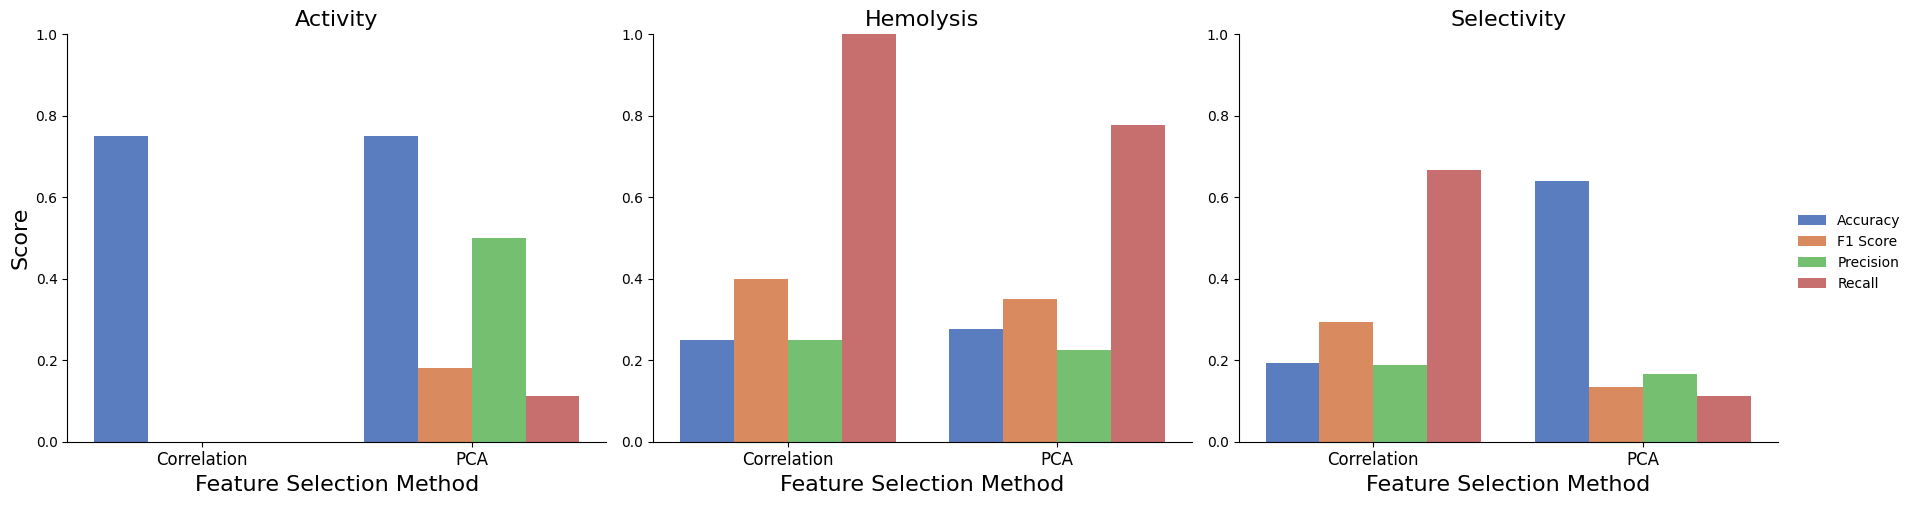

In [19]:
g = sns.FacetGrid(df_melted, col="Feature", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Version", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Feature Selection Method", "Score", size=16)


axes = g.axes.flatten()
axes[0].set_title("Activity", size=16)
axes[1].set_title("Hemolysis", size=16)
axes[2].set_title("Selectivity", size=16)

tick_labels = ['Correlation', 'PCA']
for ax in axes: 
    ax.set_xticks(range(len(tick_labels)))  # Set x-tick positions
    ax.set_xticklabels(tick_labels, size=12) 


g.add_legend()
#plt.savefig('results/model_v01-2_performance.png', dpi=1200)

In [20]:
#results.to_excel('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01-02.xlsx')